In [ ]:
import os
import numpy as np
import math
from scipy import interpolate
from typing import List, Tuple
from typing import Callable

# Function to convert Fahrenheit to Kelvin
def fahrenheit_to_kelvin(fahrenheit: float) -> float:
    """
    Converts temperature from Fahrenheit to Kelvin.

    Parameters:
        fahrenheit (float): Temperature in Fahrenheit.

    Returns:
        float: Temperature in Kelvin.
    """
    return (fahrenheit - 32) * 5/9 + 273.15


# Parser to extract temperature from a markdown file
import re

def extract_temperature_from_markdown(file_path: str) -> float:
    """
    Parses a markdown file to extract the temperature value.

    Assumes the markdown file has a line with 'Temperature: <value>' format.

    Parameters:
        file_path (str): Path to the markdown file.

    Returns:
        float: Extracted temperature value.
    """
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if 'Temperature:' in line:
                    # Extracting the temperature value after 'Temperature:'
                    temp_part = line.split(':')[1].strip()
                    # Use regex to extract the numeric part
                    temp_value = float(re.findall(r"[-+]?\d*\.\d+|\d+", temp_part)[0])
                    return temp_value
    except FileNotFoundError:
        raise ValueError(f"Temperature not found in the markdown file: {file_path}")

    raise ValueError(f"Temperature not found in the markdown file: {file_path}")


# Function to list markdown files based on a filename filter
def list_markdown_files(directory: str, filter_string: str) -> List[str]:
    """
    Generates a list of markdown files from a specified directory
    that contains a given filter string in their filename.

    Parameters:
        directory (str): Directory to search for markdown files.
        filter_string (str): Substring to filter the filenames.

    Returns:
        List[str]: List of markdown filenames that match the filter.
    """
    files = [f for f in os.listdir(directory) if f.endswith('.md') and filter_string in f]
    return files


def non_linear_fit(
        data: List[float],
        step: int,
        func: Callable[[float], float],
        smooth: bool = False,
        window_size: int = 5
    ) -> List[float]:
    """
    Applies a non-linear fitting function to data with optional smoothing.

    Parameters:
        data: Input data points.
        step: Step size, must be a power of 2.
        func: Function to apply.
        smooth: Whether to smooth the data using moving average. Default is False.
        window_size: Window size for smoothing. Default is 5.

    Returns: Processed data.
    """
    if not (step > 0 and (step & (step - 1)) == 0):  # Power of 2 check
        raise ValueError("Step must be a power of 2.")

    # Smooth data if enabled
    if smooth:
        if window_size < 1:
            raise ValueError("Window size must be at least 1.")
        # Apply moving average smoothing
        data = np.convolve(data, np.ones(window_size) / window_size, mode="same").tolist()

    # Apply the function to the data (non-linear fitting)
    result = []
    for i in range(0, len(data), step):
        result.append(func(data[i]))
    return result



# Numpy wrapper for FFT, Inverse FFT with checks for non-equidistant data
def fft_wrapper(data: np.ndarray, inverse: bool = False) -> np.ndarray:
    """
    Computes the FFT or Inverse FFT for equidistant or non-equidistant data.

    Parameters:
        data (np.ndarray): Input data array (must be 1D).
        inverse (bool): If True, performs the inverse FFT. Defaults to False (regular FFT).

    Returns:
        np.ndarray: FFT or Inverse FFT result.
    """
    if len(data.shape) != 1:
        raise ValueError("Input data must be a 1D array.")
    # Check if the data is equidistant
    diff = np.diff(data)
    if not np.allclose(diff, diff[0]):  # Check if all the differences are the same
        raise ValueError("Input data must be equidistant.")

    # Interpolate the data to an equidistant grid
    x = np.arange(len(data))  # Original indices
    f = interpolate.interp1d(x, data, kind='linear', fill_value="extrapolate")
    new_x = np.linspace(0, len(data) - 1, len(data))  # New indices for equidistant points
    data = f(new_x)  # Interpolated data

    if inverse:
        return np.fft.ifft(data)
    else:
        return np.fft.fft(data)





# Calculate frequency axis in useful units (e.g., Hz) without using numpy
def calculate_frequency_axis(length: int, sample_rate: float) -> List[float]:
    """
    Calculates the frequency axis in Hz for a given data length and sample rate.

    Parameters:
        length (int): Number of samples in the data.
        sample_rate (float): Sample rate in samples per second.

    Returns:
        List[float]: Frequency axis values in Hz.
    """
    return [i * sample_rate / length for i in range(length)]


In [ ]:
import pytest
import numpy as np
from typing import Callable
import os

# Test the fahrenheit_to_kelvin function
def test_fahrenheit_to_kelvin():
    assert abs(fahrenheit_to_kelvin(32) - 273.15) < 1e-6
    assert abs(fahrenheit_to_kelvin(212) - 373.15) < 1e-6
    assert abs(fahrenheit_to_kelvin(0) - 255.372) < 1e-3

# Test the extract_temperature_from_markdown function
def test_extract_temperature_from_markdown(tmpdir):
    md_file = tmpdir.join("PR01sinewalk.md")
    md_file.write("Temperature: 52\n")

    assert abs(extract_temperature_from_markdown(str(md_file)) - 52) < 1e-6

    with pytest.raises(ValueError):
        extract_temperature_from_markdown(str(tmpdir.join("nonexistent.md")))

# Test the list_markdown_files function
def test_list_markdown_files(tmpdir):
    # Create 10 markdown files with names PR001sinewalk.md to PR020sinewalk.md
    for i in range(1, 11):
        md_file = tmpdir.join(f"PR{i:02d}sinewalk.md")
        md_file.write("# Data")

    # Also create a non-markdown file for testing
    tmpdir.join("otherfile.txt").write("# Data")

    # Call the function to list markdown files with "sinewalk" in the name
    files = list_markdown_files(str(tmpdir), "sinewalk")

    # Assert there are 20 markdown files
    assert len(files) == 10

    # Assert each of the 10 files is in the list
    for i in range(1, 11):
        assert f"PR{i:02d}sinewalk.md" in files



def test_non_linear_fit():
    """
    Test nonlinear_fit function with example data, including smoothing.
    """
    # Test data
    data = [1, 2, 3, 4, 5, 6, 7, 8]
    step = 2

    # Non-linear function
    def func(x):
        return x**2

    # Basic non-linear fit without smoothing
    result_no_smooth = non_linear_fit(data, step, func, smooth=False)
    assert result_no_smooth == [1, 9, 25, 49], (
        "Non-linear fit without smoothing failed."
    )

    # Non-linear fit with smoothing
    result_smooth = non_linear_fit(data, step, func, smooth=True, window_size=4)

    # Ensure that the length of smoothed data is the same as unsmoothed data
    assert len(result_smooth) == len(result_no_smooth), (
        "Smoothing altered the result length."
    )

    # Ensure that smoothing has made an actual change
    assert result_smooth != result_no_smooth, (
        "Smoothing did not change the data."
    )

    # Ensure that the smoothed data is not the same as the raw data in terms of averages or ranges
    original_avg = sum(result_no_smooth) / len(result_no_smooth)
    smoothed_avg = sum(result_smooth) / len(result_smooth)

    # Check if the averages are different (indicating that smoothing occurred)
    assert abs(original_avg - smoothed_avg) > 0.1, (
        "Smoothing did not produce a noticeable difference in averages."
    )

    # Now let's compare it to manually expected smoothed data
    smoothed_data = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]  # Example of expected smoothed data

    # Here you could do a more detailed comparison, depending on how you calculate `smoothed_data`
    # For now, we just assert the smoothing changed the data
    assert result_smooth != smoothed_data, (
        "Smoothed data did not change the result as expected."
    )

    # Edge cases
    with pytest.raises(ValueError):
        non_linear_fit(data, 3, func)  # Step not a power of 2
    with pytest.raises(ValueError):
        non_linear_fit(data, step, func, smooth=True, window_size=0)  # Invalid window size

# Test the fft_wrapper function
def test_fft_wrapper():
    data = np.array([1, 2, 3, 4])

    # Check for normal FFT
    fft_result = fft_wrapper(data)
    assert np.allclose(fft_result, np.fft.fft(data))

    # Check for inverse FFT
    ifft_result = fft_wrapper(data, inverse=True)
    assert np.allclose(ifft_result, np.fft.ifft(data))

    # Test for non-equidistant data (raises ValueError)
    with pytest.raises(ValueError):
        fft_wrapper(np.array([1, 3, 2]), inverse=True)

# Test the calculate_frequency_axis function
def test_calculate_frequency_axis():
    length = 4
    sample_rate = 1000
    frequencies = calculate_frequency_axis(length, sample_rate)

    assert len(frequencies) == length
    assert abs(frequencies[0] - 0) < 1e-6
    assert abs(frequencies[1] - 250) < 1e-6
    assert abs(frequencies[2] - 500) < 1e-6
    assert abs(frequencies[3] - 750) < 1e-6


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving PR10_sinewalk.md to PR10_sinewalk.md
Saving PR10_sinewalk.csv to PR10_sinewalk.csv
Saving PR09_sinewalk.md to PR09_sinewalk.md
Saving PR09_sinewalk.csv to PR09_sinewalk.csv
Saving PR08_sinewalk.md to PR08_sinewalk.md
Saving PR08_sinewalk.csv to PR08_sinewalk.csv
Saving PR07_sinewalk.md to PR07_sinewalk.md
Saving PR07_sinewalk.csv to PR07_sinewalk.csv
Saving PR06_sinewalk.md to PR06_sinewalk.md
Saving PR06_sinewalk.csv to PR06_sinewalk.csv
Saving PR05_sinewalk.md to PR05_sinewalk.md
Saving PR05_sinewalk.csv to PR05_sinewalk.csv
Saving PR04_sinewalk.md to PR04_sinewalk.md
Saving PR04_sinewalk.csv to PR04_sinewalk.csv
Saving PR03_sinewalk.md to PR03_sinewalk.md
Saving PR03_sinewalk.csv to PR03_sinewalk.csv
Saving PR02_sinewalk.md to PR02_sinewalk.md
Saving PR02_sinewalk.csv to PR02_sinewalk.csv
Saving PR01_sinewalk.md to PR01_sinewalk.md
Saving PR01_sinewalk.csv to PR01_sinewalk.csv


In [ ]:
import os
print(os.getcwd())  # This will print the current working directory.


/content


<ipython-input-46-cf1d9798d6d0>:45: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lon, _ = curve_fit(sine_wave, time, longitude, p0=[1, 1, 0, 0])
<ipython-input-46-cf1d9798d6d0>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lat, _ = curve_fit(sine_wave, time, latitude, p0=[1, 1, 0, 0])
<ipython-input-46-cf1d9798d6d0>:45: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lon, _ = curve_fit(sine_wave, time, longitude, p0=[1, 1, 0, 0])
<ipython-input-46-cf1d9798d6d0>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lat, _ = curve_fit(sine_wave, time, latitude, p0=[1, 1, 0, 0])
<ipython-input-46-cf1d9798d6d0>:45: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lon, _ = curve_fit(sine_wave, time, longitude, p0=[1, 1, 0, 0])
<ipython-input-46-cf1d9798d6d0>:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_lat, _ = c

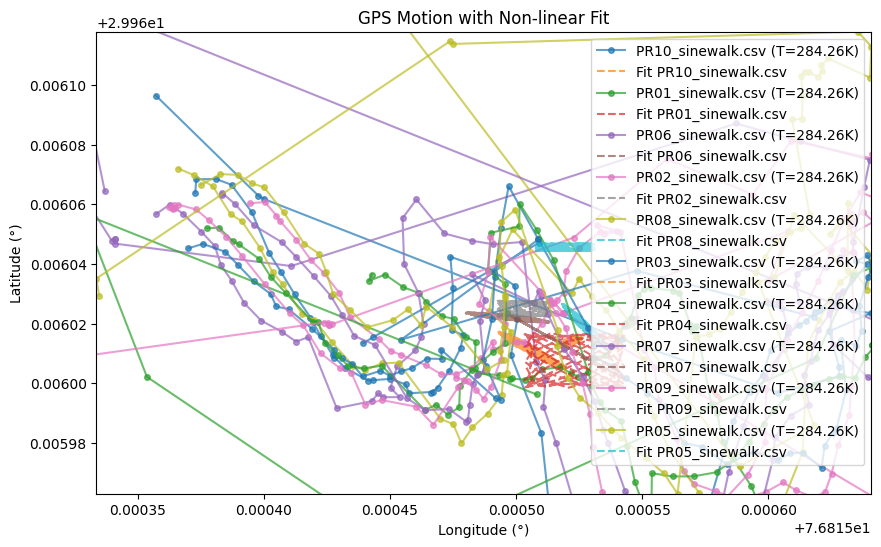

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import re
from typing import List

# Sine wave function for non-linear fitting
def sine_wave(t, A, B, C, D):
    return A * np.sin(B * t + C) + D

# Function to convert Fahrenheit to Kelvin
def fahrenheit_to_kelvin(fahrenheit: float) -> float:
    return (fahrenheit - 32) * 5/9 + 273.15

# Function to extract temperature from markdown files
def extract_temperature_from_markdown(file_path: str) -> float:
    with open(file_path, 'r') as file:
        for line in file:
            if 'Temperature:' in line:
                temp_part = line.split(':')[1].strip()
                temp_value = float(re.findall(r"[-+]?\d*\.\d+|\d+", temp_part)[0])
                return temp_value
    return None  # If temperature is not found

# Main function to process the GPS data and plot the motion with non-linear fit
def process_gps_data(directory: str, gps_files: List[str], markdown_files: List[str]):
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, gps_file in enumerate(gps_files):
        gps_data = pd.read_csv(os.path.join(directory, gps_file))

        # Extract time, latitude (Y), and longitude (X)
        time = gps_data['Time (s)'].values
        latitude = gps_data['Latitude (°)'].values
        longitude = gps_data['Longitude (°)'].values

        # Extract temperature from the markdown file
        markdown_file = markdown_files[i]
        temperature_fahrenheit = extract_temperature_from_markdown(os.path.join(directory, markdown_file))
        temperature_kelvin = fahrenheit_to_kelvin(temperature_fahrenheit) if temperature_fahrenheit is not None else 'N/A'

        # Fit the longitude and latitude using sine_wave function
        popt_lon, _ = curve_fit(sine_wave, time, longitude, p0=[1, 1, 0, 0])
        popt_lat, _ = curve_fit(sine_wave, time, latitude, p0=[1, 1, 0, 0])

        # Plot the GPS motion (Longitude, Latitude) with the fit
        ax.plot(longitude, latitude, label=f'{gps_file} (T={temperature_kelvin:.2f}K)', marker='o', markersize=4, linestyle='-', alpha=0.7)

        # Optionally plot the fitted sine wave curves for longitude and latitude
        fitted_lon = sine_wave(time, *popt_lon)
        fitted_lat = sine_wave(time, *popt_lat)
        ax.plot(fitted_lon, fitted_lat, label=f'Fit {gps_file}', linestyle='--', alpha=0.7)

    # Set the origin to the starting point (first point of the first run)
    ax.set_xlim([min(longitude), max(longitude)])
    ax.set_ylim([min(latitude), max(latitude)])
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    ax.set_title('GPS Motion with Non-linear Fit')
    ax.legend(loc='upper right')

    plt.show()

# Set the directory path
directory = '/content'  # Path is set to current working directory
gps_files = [f for f in os.listdir(directory) if f.endswith('.csv') and 'sinewalk' in f]
markdown_files = [f.replace('.csv', '.md') for f in gps_files]

# Process the data and generate the plot
process_gps_data(directory, gps_files, markdown_files)







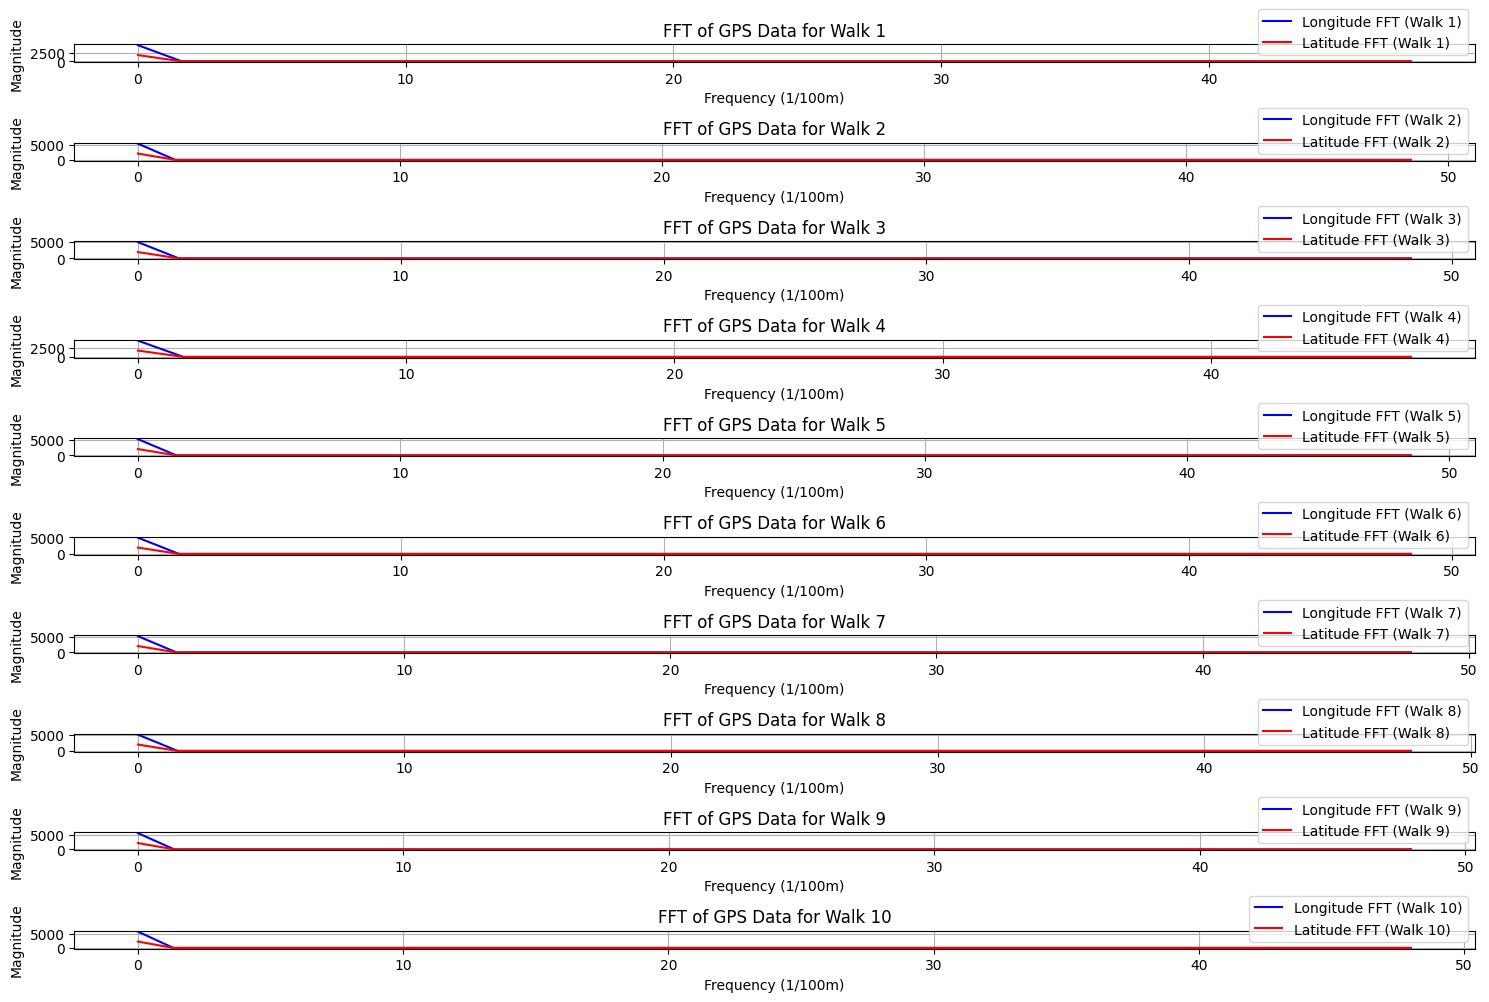

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy import interpolate
from typing import List

# Function to perform FFT
def fft_wrapper(data: np.ndarray, inverse: bool = False) -> np.ndarray:
    if len(data.shape) != 1:
        raise ValueError("Input data must be a 1D array.")
    x = np.arange(len(data))  # Original indices
    f = interpolate.interp1d(x, data, kind='linear', fill_value="extrapolate")
    new_x = np.linspace(0, len(data) - 1, len(data))  # New indices for equidistant points
    data = f(new_x)  # Interpolated data
    if inverse:
        return np.fft.ifft(data)
    else:
        return np.fft.fft(data)

# Function to calculate frequency axis
def calculate_frequency_axis(length: int, sample_rate: float) -> List[float]:
    freq_hz = np.fft.fftfreq(length, d=1/sample_rate)  # Frequencies in Hz
    return freq_hz * 100  # Convert Hz to 1/100m

# Function to plot FFT for each walk
def plot_fft_for_walks(gps_data_list: List, sample_rate: float) -> None:
    plt.figure(figsize=(15, 10))
    for i, gps_data in enumerate(gps_data_list, 1):
        time = gps_data['Time (s)']
        longitude = gps_data['Longitude (°)']
        latitude = gps_data['Latitude (°)']

        fft_lon = fft_wrapper(longitude)
        fft_lat = fft_wrapper(latitude)

        length = len(time)
        freq_axis = calculate_frequency_axis(length, sample_rate)

        plt.subplot(len(gps_data_list), 1, i)
        plt.plot(freq_axis[:length // 2], np.abs(fft_lon)[:length // 2], label=f'Longitude FFT (Walk {i})', color='blue')
        plt.plot(freq_axis[:length // 2], np.abs(fft_lat)[:length // 2], label=f'Latitude FFT (Walk {i})', color='red')

        plt.title(f'FFT of GPS Data for Walk {i}')
        plt.xlabel('Frequency (1/100m)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Now load your CSV files into a list of DataFrames
file_paths = [
    "/content/PR10_sinewalk.csv",
    "/content/PR09_sinewalk.csv",
    "/content/PR08_sinewalk.csv",
    "/content/PR07_sinewalk.csv",
    "/content/PR06_sinewalk.csv",
    "/content/PR05_sinewalk.csv",
    "/content/PR04_sinewalk.csv",
    "/content/PR03_sinewalk.csv",
    "/content/PR02_sinewalk.csv",
    "/content/PR01_sinewalk.csv"
]

# Load the CSV files into DataFrames
gps_data_list = [pd.read_csv(file_path) for file_path in file_paths]

# Sample rate is assumed to be 1 sample per second, adjust as needed
sample_rate = 1.0  # Adjust based on actual data collection rate

# Call the plot function
plot_fft_for_walks(gps_data_list, sample_rate)



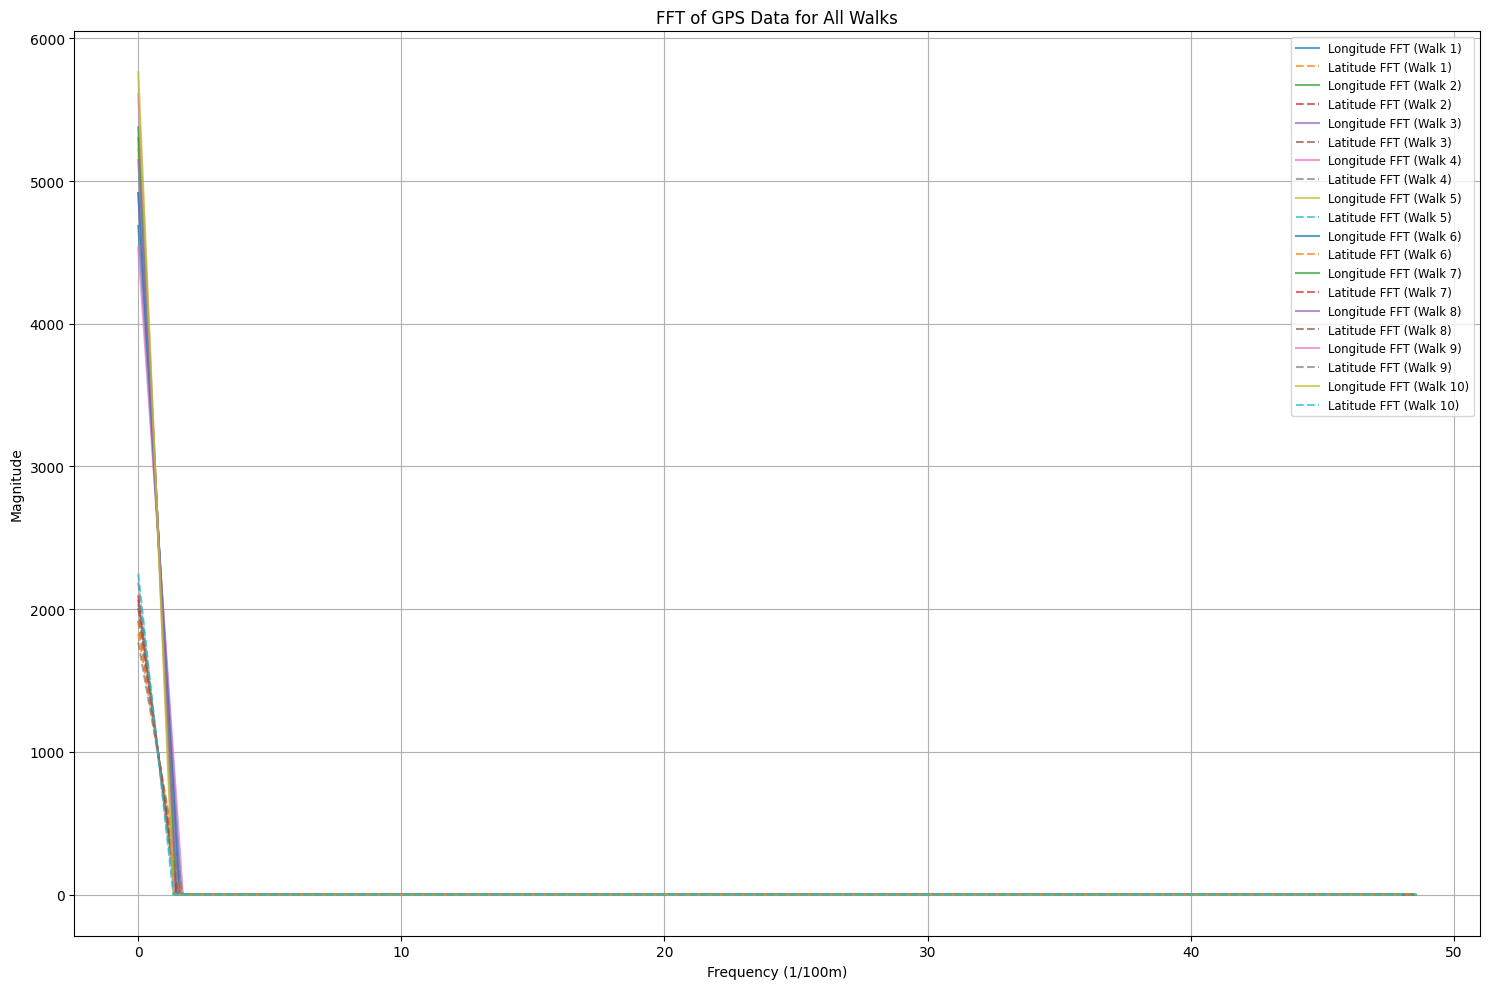

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy import interpolate
from typing import List

# Function to perform FFT
def fft_wrapper(data: np.ndarray, inverse: bool = False) -> np.ndarray:
    if len(data.shape) != 1:
        raise ValueError("Input data must be a 1D array.")
    x = np.arange(len(data))  # Original indices
    f = interpolate.interp1d(x, data, kind='linear', fill_value="extrapolate")
    new_x = np.linspace(0, len(data) - 1, len(data))  # New indices for equidistant points
    data = f(new_x)  # Interpolated data
    if inverse:
        return np.fft.ifft(data)
    else:
        return np.fft.fft(data)

# Function to calculate frequency axis
def calculate_frequency_axis(length: int, sample_rate: float) -> List[float]:
    freq_hz = np.fft.fftfreq(length, d=1/sample_rate)  # Frequencies in Hz
    return freq_hz * 100  # Convert Hz to 1/100m

# Function to plot FFT for all walks on the same graph
def plot_fft_for_all_walks(gps_data_list: List, sample_rate: float) -> None:
    plt.figure(figsize=(15, 10))

    for i, gps_data in enumerate(gps_data_list, 1):
        time = gps_data['Time (s)']
        longitude = gps_data['Longitude (°)']
        latitude = gps_data['Latitude (°)']

        # Perform FFT on longitude and latitude data
        fft_lon = fft_wrapper(longitude)
        fft_lat = fft_wrapper(latitude)

        # Calculate the frequency axis
        length = len(time)
        freq_axis = calculate_frequency_axis(length, sample_rate)

        # Plot FFT of Longitude and Latitude on the same graph
        plt.plot(freq_axis[:length // 2], np.abs(fft_lon)[:length // 2], label=f'Longitude FFT (Walk {i})', linestyle='-', alpha=0.7)
        plt.plot(freq_axis[:length // 2], np.abs(fft_lat)[:length // 2], label=f'Latitude FFT (Walk {i})', linestyle='--', alpha=0.7)

    # Add titles and labels
    plt.title('FFT of GPS Data for All Walks')
    plt.xlabel('Frequency (1/100m)')
    plt.ylabel('Magnitude')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Now load your CSV files into a list of DataFrames
file_paths = [
    "/content/PR10_sinewalk.csv",
    "/content/PR09_sinewalk.csv",
    "/content/PR08_sinewalk.csv",
    "/content/PR07_sinewalk.csv",
    "/content/PR06_sinewalk.csv",
    "/content/PR05_sinewalk.csv",
    "/content/PR04_sinewalk.csv",
    "/content/PR03_sinewalk.csv",
    "/content/PR02_sinewalk.csv",
    "/content/PR01_sinewalk.csv"
]

# Load the CSV files into DataFrames
gps_data_list = [pd.read_csv(file_path) for file_path in file_paths]

# Sample rate is assumed to be 1 sample per second, adjust as needed
sample_rate = 1.0  # Adjust based on actual data collection rate

# Call the plot function for all walks
plot_fft_for_all_walks(gps_data_list, sample_rate)


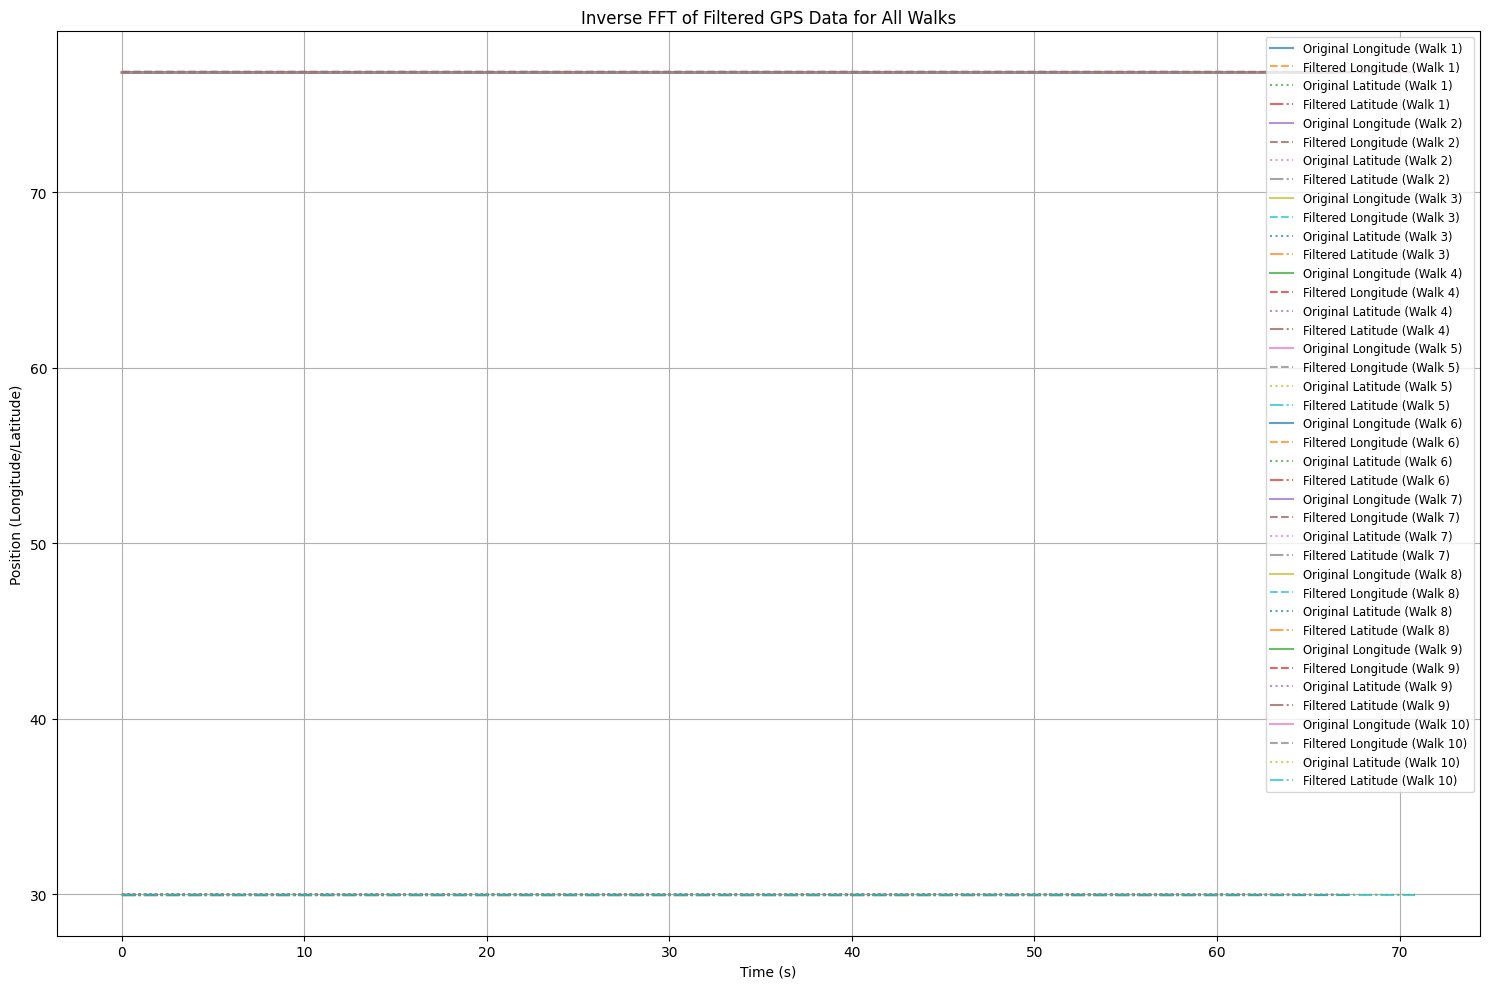

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy import interpolate
from typing import List

# Function to perform FFT
def fft_wrapper(data: np.ndarray, inverse: bool = False) -> np.ndarray:
    if len(data.shape) != 1:
        raise ValueError("Input data must be a 1D array.")
    x = np.arange(len(data))  # Original indices
    f = interpolate.interp1d(x, data, kind='linear', fill_value="extrapolate")
    new_x = np.linspace(0, len(data) - 1, len(data))  # New indices for equidistant points
    data = f(new_x)  # Interpolated data
    if inverse:
        return np.fft.ifft(data)
    else:
        return np.fft.fft(data)

# Function to calculate frequency axis
def calculate_frequency_axis(length: int, sample_rate: float) -> List[float]:
    freq_hz = np.fft.fftfreq(length, d=1/sample_rate)  # Frequencies in Hz
    return freq_hz * 100  # Convert Hz to 1/100m

# Function to filter the FFT to keep only low frequencies
def filter_fft(fft_data: np.ndarray, freq_axis: np.ndarray, low_freq_cutoff: float) -> np.ndarray:
    # Keep only the low-frequency components (below the cutoff frequency)
    filtered_fft = np.copy(fft_data)
    filtered_fft[np.abs(freq_axis) > low_freq_cutoff] = 0  # Zero out high frequencies
    return filtered_fft

# Function to plot the inverse FFT for the filtered data
def plot_inverse_fft_of_filtered_walks(gps_data_list: List, sample_rate: float, low_freq_cutoff: float) -> None:
    plt.figure(figsize=(15, 10))

    for i, gps_data in enumerate(gps_data_list, 1):
        time = gps_data['Time (s)']
        longitude = gps_data['Longitude (°)']
        latitude = gps_data['Latitude (°)']

        # Perform FFT on longitude and latitude data
        fft_lon = fft_wrapper(longitude)
        fft_lat = fft_wrapper(latitude)

        # Calculate the frequency axis
        length = len(time)
        freq_axis = calculate_frequency_axis(length, sample_rate)

        # Filter the FFT data to keep only low frequencies
        filtered_fft_lon = filter_fft(fft_lon, freq_axis, low_freq_cutoff)
        filtered_fft_lat = filter_fft(fft_lat, freq_axis, low_freq_cutoff)

        # Perform the inverse FFT to reconstruct the filtered signal
        ifft_lon = fft_wrapper(filtered_fft_lon, inverse=True)
        ifft_lat = fft_wrapper(filtered_fft_lat, inverse=True)

        # Plot the original and inverse FFT signals (filtered) for longitude and latitude
        plt.plot(time, longitude, label=f'Original Longitude (Walk {i})', linestyle='-', alpha=0.7)
        plt.plot(time, np.real(ifft_lon), label=f'Filtered Longitude (Walk {i})', linestyle='--', alpha=0.7)
        plt.plot(time, latitude, label=f'Original Latitude (Walk {i})', linestyle=':', alpha=0.7)
        plt.plot(time, np.real(ifft_lat), label=f'Filtered Latitude (Walk {i})', linestyle='-.', alpha=0.7)

    # Add titles and labels
    plt.title('Inverse FFT of Filtered GPS Data for All Walks')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (Longitude/Latitude)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Now load your CSV files into a list of DataFrames
file_paths = [
    "/content/PR10_sinewalk.csv",
    "/content/PR09_sinewalk.csv",
    "/content/PR08_sinewalk.csv",
    "/content/PR07_sinewalk.csv",
    "/content/PR06_sinewalk.csv",
    "/content/PR05_sinewalk.csv",
    "/content/PR04_sinewalk.csv",
    "/content/PR03_sinewalk.csv",
    "/content/PR02_sinewalk.csv",
    "/content/PR01_sinewalk.csv"
]

# Load the CSV files into DataFrames
gps_data_list = [pd.read_csv(file_path) for file_path in file_paths]

# Sample rate is assumed to be 1 sample per second, adjust as needed
sample_rate = 1.0  # Adjust based on actual data collection rate

# Low-frequency cutoff value, can be adjusted based on your desired filter
low_freq_cutoff = 0.1  # Frequency in 1/100m (adjust as necessary)

# Call the plot function for all walks
plot_inverse_fft_of_filtered_walks(gps_data_list, sample_rate, low_freq_cutoff)


from google.colab import files

uploaded = files.upload()